In [1]:
import pandas as pd
import numpy as np
import yaml
import time
import matplotlib.pyplot as plt
from functools import partial
from typing import Any, Set, Tuple, List, Dict, Union, Optional
import gc
gc.enable()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import download_url, extract_zip, HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.nn.conv import MessagePassing
import torch_geometric.transforms as T
from torch_geometric import EdgeIndex
from torch_geometric.utils import add_self_loops, spmm, is_sparse
from torch_geometric.typing import Adj, OptPairTensor, SparseTensor

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../scripts')
from utils import generate_slot_data, generate_heist_data, generate_thief_data, conflict_interval, conflict_schedule, is_unqualified

In [2]:
# Vectorize conflict_interval
vconflict_interval = np.vectorize(conflict_interval)

In [3]:
config_problemdef_PATH = '../configs/v1_problemdef.yaml'
with open(config_problemdef_PATH, 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

schedule_size = config['schedule_size']
qual_size = len(config['qualifications'])
sat_size = len(config['job_satisfaction'])
heist_size = len(config['heist_features'])
slot_size = len(config['slot_features']) + qual_size + sat_size
thief_size = schedule_size + qual_size + sat_size

In [4]:
# Load generation parameters
config_params_PATH = '../configs/v1_params.yaml'
with open(config_params_PATH, 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

sdchedule_size = config['schedule_size']
heist_dur_max = config['heist_dur_max']
n_slots_max = config['n_slots_max']
n_slots_min = config['n_slots_min']
n_heists_max = config['n_heists_max']
n_heists_min = config['n_heists_min']
qual_max = config['qual_max']
qual_min = config['qual_min']
sat_max = config['sat_max']
sat_min = config['sat_min']

In [5]:
# Set partial functions using problem definition sizes
generate_heist_data = partial(generate_heist_data, schedule_size, heist_dur_max, n_slots_max, n_slots_min)
generate_thief_data = partial(generate_thief_data, schedule_size, n_heists_max, n_heists_min, qual_max, qual_min, qual_size, sat_max, sat_min, sat_size)
generate_slot_data = partial(generate_slot_data, qual_max, qual_min, qual_size, sat_size)

In [6]:
# Hard code features to idx mappings
featidx_h_start = 0
featidx_h_end = 1
featidx_h_n_slots = 2
featidx_h_n_slots_req = 3
featidx_t_schedule = (0,schedule_size)
featidx_t_qual = (schedule_size, schedule_size + qual_size)
featidx_t_sat = (schedule_size + qual_size, thief_size)
featidx_s_req = 0
featidx_s_qual = (1, qual_size+1)
featidx_s_sat = (qual_size+1, slot_size)

In [7]:
def remove_edges(edge_index: torch.tensor, remove_idx: Any) -> Any:
    """ Given edge_index tensor, array of idx in ascending order to remove -> return new view of edge_index """
    keep_idx = np.arange(edge_index.shape[1])
    keep_idx = np.delete(keep_idx, remove_idx)
    return edge_index[:,keep_idx]

In [53]:
class CustomEnvironment():
    def __init__(self,**config):
        pass

    def reset(self, **kwargs):

        n_thieves = 30
        n_heists = 50

        self.init_indices()
        self.init_dictionaries()
        self.heist_df = self.gen_n_heists(n_heists) # will update index_d_heist1, index_d_heist2 in place
        self.slot_df = self.gen_n_slots() # will update index_c_slot, index_c_heist, heist2slot, slot2heist in place
        self.thief_df = self.gen_n_thieves(n_thieves) # will update index_a_thief, index_a_slot, slot2thief in place

        self.data = self.reset_data()
        self.reward = None
        self.termination = False
        self.timestep = 0

    def step(self, edge_idx): # NOTE: editing self.data inplace except for self.index_b_thief, self.index_b_slot, self.thiefslot2idx
        
        self.reward = 0
        self.timestep += 1

        # Check for termination
        if not self.thiefslot2idx or self.timestep > 999:
            self.termination = True

            # Penalize unsatisfied thieves
            self.reward -= self.data['thief'].x[:,featidx_t_sat[0]: featidx_t_sat[1]].sum()
            # Penalize grounded assignments
            for h, crew in self.heist2assigned.items():
                  reward_num_assignments = len(crew)
                  reward_time = self.data['heist'].x[h][featidx_h_end] - self.data['heist'].x[h][featidx_h_start]
                  self.reward -= reward_num_assignments + reward_time
            return self.data, self.reward, self.termination, self.timestep
        
        thief = self.data['thief','possible','slot'].edge_index[0, edge_idx].item() # NOTE: cannot use self.index_a_thief, since it's not updated
        slot = self.data['thief','possible','slot'].edge_index[1, edge_idx].item()
        
        # Step 1: Add (thief, slot) to index_b
        self.index_b_thief.append(thief)
        self.index_b_slot.append(slot)
        self.data['thief','assigned','slot'].edge_index = torch.stack([torch.tensor(self.index_b_thief), torch.tensor(self.index_b_slot)])
        # NOTE: more efficient way?

        # Step 2: Add (thief, slot) to heist2assigned dictionary
        heist = self.slot2heist[slot]
        if self.heist2assigned.get(heist):
            self.heist2assigned[heist].append((thief, slot))
        else: self.heist2assigned[heist] = [(thief, slot)]

        # Step 3: Remove (t, s) edges from index_a based on constraints
        remove_idx = self.constraint2(thief, heist) + self.constraint3(slot)
        self.data['thief','possible','slot'].edge_index = remove_edges(self.data['thief','possible','slot'].edge_index, remove_idx)   
        # Update thiefslot2idx wholesale
        self.thiefslot2idx = {(k1.item(), k2.item()):v for k1,k2,v in zip(self.data['thief','possible','slot'].edge_index[0],self.data['thief','possible','slot'].edge_index[1],np.arange(self.data['thief','possible','slot'].edge_index.shape[1]))}

        # Step 4: Update thief schedule (Already accomplished through Step 2, Substep 3)
        self.data['thief'].x[thief][featidx_t_schedule[0]: featidx_t_schedule[1]] = 1

        # Step 5: Check for takeoff and calculate reward
        if not self.data['heist'].x[heist][featidx_h_n_slots_req]: # already taken off
            self.reward += self.calculate_reward_qual_sat(thief, slot)
            # Update thief information
            self.update_thief_sat(thief, slot)
        elif self.data['heist'].x[heist][featidx_h_n_slots_req] == 1 and self.data['slot'].x[slot][featidx_s_req]: # currently taking off
            self.reward += self.calculate_reward_qual_sat(thief, slot)
            # Update thief information
            self.update_thief_sat(thief, slot)
            # Update previous crew information
            crew = self.heist2assigned[heist]
            for (t,s) in crew:
                self.reward += self.calculate_reward_qual_sat(t,s)
                # Update previous thieves
                self.update_thief_sat(t,s)
        else: # currently grounded
            self.reward += self.calculate_reward_qual_sat(thief, slot)

        # Step 6: Update heist information
        self.data['heist'].x[heist][featidx_h_n_slots] -= 1
        if self.data['slot'].x[slot][featidx_s_req]:
            self.data['heist'].x[heist][featidx_h_n_slots_req] -= 1

        # print(len(self.thiefslot2idx), self.data['thief','possible','slot'].edge_index.shape)
        return self.data, self.reward, self.termination, self.timestep

    def init_indices(self):
        self.index_a_thief, self.index_a_slot = [], []      # NOTE: DISREGARD AFTER INIT
        self.index_b_thief, self.index_b_slot = [], []
        self.index_c_slot, self.index_c_heist = [], []
        self.index_d_heist1, self.index_d_heist2 = [], []
    
    def init_dictionaries(self):
        self.heist2slot = {}
        self.heist2heist = {}
        self.slot2heist = {}
        self.slot2thief = {}

        # Assignment dictionaries
        self.heist2assigned = {}
        self.thiefslot2idx = {}

    def gen_n_heists(self, n_heists): # TODO: add optional config file of size n_heists x dims
        heist_df = pd.DataFrame()
        for h in range(n_heists):
            # Get heist data
            heist_data = generate_heist_data()

            # Add to heist_df
            tmp_df = pd.DataFrame(heist_data).T
            tmp_df.index = [h]
            heist_df = pd.concat([heist_df, tmp_df])

        heist_df.index.rename('heistId', inplace=True)

        # Update index_d and heist2heist dictionary (O(n^2))
        for h, row in heist_df.iterrows():
            conflicts = vconflict_interval(heist_df[featidx_h_start].values, heist_df[featidx_h_end].values,
                                            row[featidx_h_start], row[featidx_h_end])                        
            # [conflict_interval(row[featidx_h_start], row[featidx_h_end], x, y) for x,y in zip(heist_df[featidx_h_start].values, heist_df[featidx_h_end].values)]
            indices = np.where(conflicts)[0] # list(np.compress(heist_df.index, conflicts))
            self.heist2heist[h] = indices
            for h2 in indices:
                self.index_d_heist1.append(h)
                self.index_d_heist2.append(h2)

        return heist_df
    
    def gen_n_slots(self): 
        i = 0 # counter of total slots so far
        slot_df = pd.DataFrame()
        # For each heist
        for h, heist in self.heist_df.iterrows():
            # Number of slots per heist
            n_slots: int = int(heist[featidx_h_n_slots])
            n_slots_req: int= heist[featidx_h_n_slots_req]
            
            # For each slots
            for s in range(n_slots):
                # Get slot data based on required status
                slot_data: Any = generate_slot_data(required=(s < n_slots_req))

                # Update index_c
                self.index_c_slot.append(i)
                self.index_c_heist.append(h)

                # Update heist2slot and slot2heist dictionaries
                if h in self.heist2slot: self.heist2slot[h].append(i)
                else: self.heist2slot[h] = [i]
                self.slot2heist[i] = h

                # Add to slot_df
                tmp_df = pd.DataFrame(slot_data).T
                tmp_df.index = [i]
                slot_df = pd.concat([slot_df, tmp_df])

                i += 1 # update slot counter
            
        slot_df.index.rename('slotId', inplace=True)
        return slot_df
    
    def gen_n_thieves(self, n_thieves): 
        i = 0 # counter of total edges
        thief_df = pd.DataFrame()
        # For each thief
        for t in range(n_thieves):
            # Get thief data
            thief_data = generate_thief_data()
            schedule = thief_data[featidx_t_schedule[0]: featidx_t_schedule[1]]

            # Create thief-slot edges
            # For each heist
            for h, heist in self.heist_df.iterrows():
                # If schedule conflict: no edge
                if conflict_schedule(schedule, heist[featidx_h_start], heist[featidx_h_end]):
                    continue
                # If no schedule conflict: get indices of slot on heist
                slot_idx = self.heist2slot[h]
                # For each eligible slot
                for s in slot_idx:
                    # If thief unqualified: no edge
                    thief_qual = thief_data[featidx_t_qual[0]: featidx_t_qual[1]]
                    slot_qual = self.slot_df.iloc[s, featidx_s_qual[0]: featidx_s_qual[1]]
                    if is_unqualified(thief_qual, slot_qual):
                        continue
                    # If thief qualified: update index_a
                    self.index_a_thief.append(t)
                    self.index_a_slot.append(s)
                    # Update slot2thief dictionary
                    if self.slot2thief.get(s): self.slot2thief[s].append(t) 
                    else: self.slot2thief[s] = [t]                    
                    # Update thiefslot2idx dictionary
                    self.thiefslot2idx[(t,s)] = i
                    i += 1
        
            # Add to thief_df
            tmp_df = pd.DataFrame(thief_data).T
            tmp_df.index = [t]
            thief_df = pd.concat([thief_df, tmp_df])

        thief_df.index.rename('thiefId', inplace=True)
        return thief_df

    def reset_data(self):
        index_a = torch.stack([torch.tensor(self.index_a_thief), torch.tensor(self.index_a_slot)])
        index_b = torch.stack([torch.tensor(self.index_b_thief), torch.tensor(self.index_b_slot)])
        index_c = torch.stack([torch.tensor(self.index_c_slot), torch.tensor(self.index_c_heist)])
        index_d = torch.stack([torch.tensor(self.index_d_heist1), torch.tensor(self.index_d_heist2)])

        data = HeteroData()

        # Add node indices
        data['thief'].node_id = torch.tensor(self.thief_df.index)
        data['slot'].node_id = torch.tensor(self.slot_df.index)
        data['heist'].node_id = torch.tensor(self.heist_df.index)

        # Add node features
        data["thief"].x = torch.tensor(self.thief_df.values).to(torch.float)
        data["slot"].x = torch.tensor(self.slot_df.values).to(torch.float)
        data["heist"].x = torch.tensor(self.heist_df.values).to(torch.float)

        # Add edge indices
        data["thief","possible","slot"].edge_index = index_a # has shape (2, num_edges)
        data["thief","assigned","slot"].edge_index = index_b # has shape (2, num_edges)
        data["slot","on","heist"].edge_index = index_c # has shape (2, num_edges)
        data["heist1","conflicts","heist2"].edge_index = index_d # has shape (2, num_edges)

        # Add reverse edge
        data = T.ToUndirected()(data)
        return data

    # def constraint1(self, thief: int, heist: int) -> List:
    #     """ Given (thief, heist) pair, find edges that violate constraint 1: one person per heist """
    #     slots: List = self.heist2slot[slot] if self.heist2slot.get(heist) is not None else []
    #     idx  : List = [self.thiefslot2idx[(thief,s)] for s in slots if (thief,s) in self.thiefslot2idx]
    #     return idx
    
    def constraint2(self, thief: int, heist: int) -> List:
        """ Given (thief, heist) pair, find edges that violate constraint 2: thief cannot be assigned to conflicting heists """
        conflicting_heists: List = self.heist2heist[heist] if heist in self.heist2heist else []
        # print(heist, conflicting_heists)
        slots : List = []
        for h in conflicting_heists:
            slots += (self.heist2slot[h] if h in self.heist2slot else [])
        idx : List = [self.thiefslot2idx[(thief,s)] for s in slots if s if (thief,s) in self.thiefslot2idx]
        return idx

    def constraint3(self, slot: int) -> List:
        """ Given a slot, find edges that violate constraint 3: only one person per slot """
        thieves : List = self.slot2thief.pop(slot) if slot in self.slot2thief else []
        idx : List = [self.thiefslot2idx[(t,slot)] for t in thieves if (t,slot) in self.thiefslot2idx]
        return idx
    
    def calculate_reward_qual_sat(self, thief: int, slot: int) -> float:
        """ Given index for thief and slot, calculate overqual and satisfaction reward """
        thief_satisfaction = self.data['thief'].x[thief][featidx_t_sat[0]: featidx_t_sat[1]]
        thief_quals        = self.data['thief'].x[thief][featidx_t_qual[0]: featidx_t_qual[1]]
        slot_satisfaction  = self.data['slot'].x[slot][featidx_s_sat[0]: featidx_s_sat[1]]
        slot_quals         = self.data['slot'].x[slot][featidx_s_qual[0]: featidx_s_qual[1]]
        reward_overquals = (thief_quals - slot_quals).sum()
        reward_satisfaction = (thief_satisfaction * slot_satisfaction).sum()
        return reward_satisfaction - reward_overquals

    def update_thief_sat(self, thief: int, slot: int) -> None:
        """ Given index for thief, slot, update thief information in place """
        slot_sat = self.data['slot'].x[slot][featidx_s_sat[0]: featidx_s_sat[1]]
        self.data['thief'].x[thief][featidx_t_sat[0]: featidx_t_sat[1]] *= (1 - slot_sat)

    #TODO: sets instead of lists?
    #TODO: unit tests, make sure (heist in conflicting_heists) in constraint2, check sizes

In [41]:
env = CustomEnvironment()
env.reset()

In [ ]:
env.step(0)

In [27]:
gc.collect()

525

In [ ]:
""" Update
edge_idx = argmax(index_a edges)
thief, slot = index_a[edge_idx]
1. Add (thief, slot) to index_b
2. Add (thief, slot) to heist2assigned dictionary   MUTABLE, id: list of tuple(id, id)
    Get heist = slot2heist[slot] dictionary         IMMUTABLE, id: id
    heist2assigned[heist].append(thief, slot)
3. Remove possible slots from index_a
    - Remove (thief, slot)
        idx = thiefslot2idx[(thief, slot)]          MUTABLE, tuple of ids: edge index
    - Remove (thief, s) where s is other slots that belong to heist
        Get s = heist2slot[heist] dictionary        IMMUTABLE, id: list of ids
        idx = thiefslot[(thief, s)] for each s
    - Remove (thief, s) where s is slots that belong to h, where h is heists conflicting with heist
        Get h = heist2heist[heist] dictionary       IMMUTABLE, id: lis of ids
        Get s = heist2slot[h] for each h
        idx = thiefslot2idx[(thief, s)] for each s
    - Remove (t, slot) where t is other thieves connected to slot
        Get t = slot2thief[slot] dictionary         MUTABLE, id: list of ids
        idx = thiefslot2idx[(t, slot)] for each t
    - Update index_a = index_a[!idx]
    - Update thiefslot2idx wholesale
        thiefslot[(edge[0],edge[1])] = i for i, edge in enumerate(new index_a)
4. Update thief schedule (Already accomplished through Step 2, Substep 3)   IN PLACE
    data['thief'].x[thief][featidx_t_schedule[0]: featidx_t_schedule[1]] = 1
5. Check for takeoff
    - If not data['heist'].x[heist][featidx_h_n_slots_req]: already taken off
        Reward += w1 * (reward_satisfaction - reward_overquals)
        - Update thief satisfaction                   IN PLACE
            data['thief'].x[t][featidx_t_sat[0]: featidx_t_sat[1]] *= (1 - slot_sat)
    - If data['heist'].x[heist][featidx_h_n_slots_req] == 1 and data['slot'].x[slot][featidx_s_req]: currently taking off
        Reward += w1 * (reward_satisfaction - reward_overquals)
        - Update previous crew information
            Lst = heist2assigned[heist]
            - For t,s pair in lst:
                Reward +=1 w1 * (reward_satisfaction - reward_overquals)
                - Update thief satisfaction         IN PLACE
                    data['thief'].x[t][featidx_t_sat[0]: featidx_t_sat[1]] *= (1 - slot_sat)
    - Else: currently grounded
        Reward += w2 * (reward_satisfaction - reward_overquals)
    - Reward satisfaction
        thief_satisfaction = data['thief'].x[thief][featidx_t_sat[0]: featidx_t_sat[1]]
        thief_quals        = data['thief'].x[thief][featidx_t_qual[0]: featidx_t_qual[1]]
        slot_satisfaction = data['slot'].x[slot][featidx_s_sat[0]: featidx_s_sat[1]]
        slot_quals        = data['slot'].x[slot][featidx_s_qual[0]: featidx_s_qual[1]]
        reward_overquals = (thief_quals - slot_quals).sum()
        reward_satisfaction = (thief_satisfaction * slot_satisfaction).sum()
6. Update heist information                         IN PLACE
    data['heist'].x[heist][featidx_h_n_slots] -= 1
    - If data['slot'].x[slot][featidx_s_req]:
        data['heist'].x[heist][featidx_h_n_slots_req] -= 1
7. Check for termination
    - If not index_a.numel(): no more possible slots
        Reward -= data['thief'].x[:,featidx_t_sat[0]: featidx_t_sat[1]].sum() # Unsatisfied thiefs
        - Punish grounded assignments:
            - For h in data['heist'].x:
                - If data['heist'].x[featidx_h_n_slots_req]: grounded heist
                    reward_num_assignments += len(heist2assigned[heist])
                    reward_time += data['heist'].x[h][featidx_h_end] - data['heist'].x[h][featidx_h_start]
                    Reward -= w3 * (reward_num_assignments + reward_time)
"""

In [ ]:
# avg = []
# for _ in range(1000):
#     start = time.time()
#     for i, row in env.heist_df.iterrows():
#         conflicts = [conflict_interval(row[featidx_h_start], row[featidx_h_end], x, y) for x,y in zip(start_times, end_times)]
#         indices = np.where(conflicts)
#         heist2heist[i] = indices[0]
#     end = time.time()
#     avg.append(end - start)
# # plt.plot(np.arange(1000), avg)
# print(sum(avg)/1000) # 0.0073 -> 0016

# f = np.vectorize(conflict_interval)

# avg = []
# for _ in range(1000):
#     start = time.time()
#     for i, row in env.heist_df.iterrows():
#         conflicts = f(start_times, end_times, row[featidx_h_start], row[featidx_h_end])
#         indices = np.where(conflicts)
#         heist2heist[i] = indices[0]
#     end = time.time()
#     avg.append(end - start)
# # plt.plot(np.arange(1000), avg)
# print(sum(avg)/1000)

# indices = list(np.compress(heist_df.index, conflicts))

In [ ]:
# avg = []
# for _ in range(1000):
#     lst1 = np.arange(2000).tolist()
#     lst2 = np.arange(2000).tolist()

#     tensor = torch.stack([torch.tensor(lst1), torch.tensor(lst2)])
#     idx = np.arange(0,2000,50).tolist()
#     start = time.time()
#     for i in idx:
#         _ = lst1.pop(i)
#         _ = lst2.pop(i)
#     tensor = torch.stack([torch.tensor(lst1), torch.tensor(lst2)])
#     end = time.time()
#     avg.append(end - start)
# print("List pop time: ", sum(avg) / 1000)
# plt.plot(np.arange(1000), avg)

# avg = []
# for _ in range(1000):
#     lst1 = np.arange(2000).tolist()
#     lst2 = np.arange(2000).tolist()

#     tensor = torch.stack([torch.tensor(lst1), torch.tensor(lst2)])
#     idx = np.arange(0,2000,50).tolist()

#     start = time.time()
#     keep_idx = np.arange(tensor.shape[1])
#     keep_idx = np.delete(keep_idx, idx, 0)
#     tensor = tensor[:,keep_idx]
#     end = time.time()
#     avg.append(end - start)
# print("In place time: ", sum(avg) / 1000)
# plt.plot(np.arange(1000), avg) # 0.0035 -> 0.000055

In [ ]:
# if k in dict vs if dict.get(k) is not None

0.38651065587997435


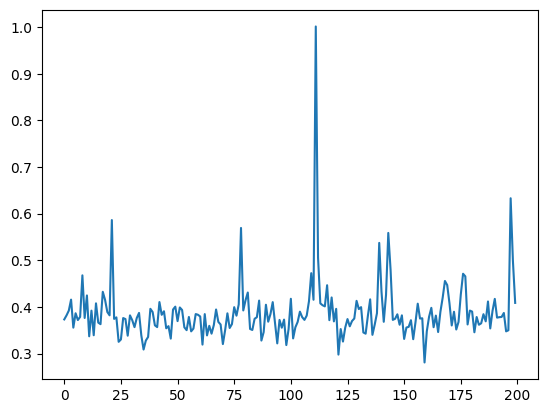

In [46]:
# avg = []
# for i in range(200):
#     start = time.time()
#     env = CustomEnvironment()
#     env.reset()
#     end = time.time()
#     avg.append(end - start)
# print(sum(avg)/len(avg))
# plt.plot(np.arange(len(avg)), avg)

0.0003474999053275537


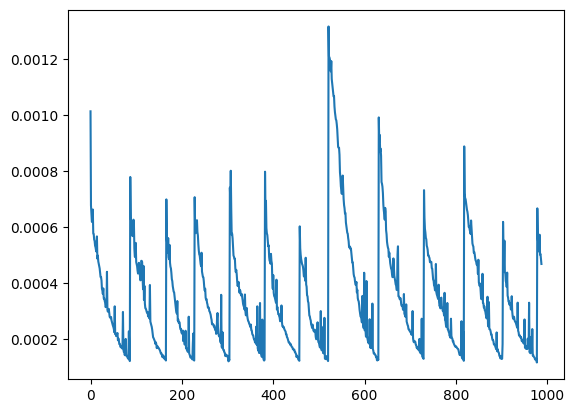

In [55]:
# avg = []
# env = CustomEnvironment()
# env.reset()
# i = 0
# for i in range(1000):
#     if env.thiefslot2idx:
#         idx = np.random.randint(len(env.thiefslot2idx))
#     else:
#         env.reset()
#         continue
#     start = time.time()
#     env.step(idx)
#     end = time.time()
#     avg.append(end - start)
#     if env.termination:
#         break
# print(sum(avg)/len(avg))
# plt.plot(np.arange(len(avg)), avg)

In [ ]:
# 9:30 -> 3:45, 6:45 - 8